In [1]:
# section 1 
#@tab pytorch
from d2l import torch as d2l
import torch
from torch import nn

In [14]:
# section 2 
#@tab pytorch
#@save
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_embeddings=num_users, embedding_dim=num_factors)
        self.Q = nn.Embedding(num_embeddings=num_items, embedding_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + torch.squeeze(b_u) + torch.squeeze(b_i)
        return outputs.flatten()

In [67]:
# section 3 
#@tab pytorch
#@save
# RMSE loss based on https://discuss.pytorch.org/t/rmse-loss-function/16540/4
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        total = 0
        for yh, yg in zip(yhat, y):
            total += self.mse(yh, yg) + self.eps
        loss = torch.sqrt(total)
        return loss

def evaluator(net, test_iter, devices):
    rmse = RMSELoss()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = nn.parallel.scatter(users, devices)
        i = nn.parallel.scatter(items, devices)
        r_ui = nn.parallel.scatter(ratings, devices)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse_list.append(rmse(r_ui, r_hat))
    return float(torch.mean(torch.tensor(rmse_list)))

In [77]:
# section 4 
#@tab pytorch
#@save
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    def init_weights(layer):
        if type(layer) == nn.Embedding:
            torch.nn.init.normal_(layer.weight, std=0.01)
    net.apply(init_weights)
    # Set the model on multiple GPUs
    net = nn.DataParallel(net, device_ids=devices)
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            trainer.zero_grad()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(nn.parallel.scatter(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = [x.float() for x in input_data[-1]]
            preds = [net(*t).float() for t in zip(*train_feat)]
            ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l for l in ls]).mean() / len(devices)
            trainer.step()
            metric.add(l, values[0].shape[0], values[0].numel())
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'], devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = (l / (i + 1)).cpu().detach().numpy()
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [11]:
import os
import pandas as pd
import torch
from d2l import torch as d2l

d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in torch.rand(
            (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = torch.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)

    class ML100KDataset(torch.utils.data.Dataset):
        def __init__(self, users, items, ratings):
            assert len(users) == len(items) == len(ratings)
            self.users = users
            self.items = items
            self.ratings = ratings

        def __getitem__(self, index):
            return (self.users[index], self.items[index],
                    self.ratings[index])

        def __len__(self):
            return len(self.users)

    train_set = ML100KDataset(train_u, train_i, train_r)
    test_set = ML100KDataset(test_u, test_i, test_r)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                      drop_last=True)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size)
    return num_users, num_items, train_iter, test_iter

In [12]:
# section 5 
#@tab pytorch
devices = d2l.try_all_gpus()

# num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
#     test_ratio=0.1, batch_size=512)
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)

/tmp/ipykernel_93/3837941072.py:59: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_ml100k()


train loss 0.129, test RMSE 1.034
377580.1 examples/sec on [device(type='cuda', index=0)]


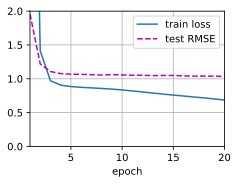

In [78]:
net = MF(30, num_users, num_items)
lr, num_epochs, wd = 0.002, 20, 1e-5
loss = nn.MSELoss()
trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

In [79]:
# section 6
#@tab pytorch
scores = net(torch.tensor([20], dtype=torch.int, device=devices[0]),
             torch.tensor([30], dtype=torch.int, device=devices[0]))
scores

tensor([2.8488], device='cuda:0', grad_fn=<AddBackward0>)